In [1]:
import pandas                   as pd
import numpy                    as np
import matplotlib.pyplot        as plt
import seaborn                  as sns
import iirsBenchmark.regressors as regressors

import Auxiliary
import re

from sympy            import sympify
from IPython.display  import display
from CriticalDiagrams import draw_cd_diagram
from ExpressionParser import count_expression_nodes


# Setting everything up
Auxiliary.create_global_file_path_variables(results_path='../../results')
Auxiliary.set_mpl_sns_params(abnt=False)

%matplotlib inline

analyzed_path = f'../post hoc analysis files/' # Where to save the plots

In [2]:
def post_processing_regression_models(info_to_extract, index=False, digest=True):
    
    data = None
    
    # Only methods that returns an analytical expression
    for regressor in ['ITEA_regressor', 'Linear_regressor', 'Lasso_regressor', 'Operon_regressor']:
        df_regression = pd.read_csv(f'{Auxiliary.regression_path}{regressor}.csv')

        regressor_no_sufix = regressor.replace('_regressor', '')

        cols = [col_name for col_name in df_regression.columns
                if col_name.startswith(info_to_extract)]

        def simplify_and_count_nodes(s):
            try:
                return count_expression_nodes(
                    str(
                        sympify(
                            s.replace("^", "**").replace('id', '')
                        )
                    ).replace("**", "^")
                )
            except Exception as e:
                #print(e)
                return np.nan
        
        df_regression[f'expr_size_{regressor_no_sufix}'] = \
            df_regression['text_representation'].apply(simplify_and_count_nodes)
        
        df_regression[f'text_representation_{regressor_no_sufix}'] = \
            df_regression['text_representation']
        
        df_regression = df_regression.drop('text_representation', axis=1)
        
        if digest == False:
            data = df_regression if data is None else pd.merge(
                data, df_regression, on="dataset", how='outer')
            
            continue

        new_df = df_regression[['dataset']].reset_index(drop=True).join(
            pd.DataFrame(
                df_regression.loc[:, cols+[f'expr_size_{regressor_no_sufix}']].values,
                columns=cols+[f'expr_size_{regressor_no_sufix}']
            )
        ).groupby(['dataset']).mean().reset_index(level=[0])

        new_df.columns = [
            col_name + f'_{regressor_no_sufix}' if col_name.startswith(info_to_extract) else col_name
            for col_name in new_df.columns]
    
        data = new_df if data is None else pd.merge(
            data, new_df, on="dataset", how='outer')

    if index:
        data.set_index('dataset', inplace=True)
        
    return data

In [3]:
df_expressions = results_regression_analysis_models('rmse_test', index=True, digest=False)

display(df_expressions)

top1 = pd.read_csv(
    '../../datasets/FeynmanEquations.csv')[['Filename', '# variables']].nlargest(1, '# variables')

for regressor in ['ITEA', 'Operon', 'Lasso', 'Linear']:
    display(df_expressions.nsmallest(1, f'expr_size_{regressor}')[[f'text_representation_{regressor}', f'expr_size_{regressor}']].values[0])

ITEA_regressor
Linear_regressor
Lasso_regressor
Operon_regressor


,rep_x,rmse_train_x,rmse_test_x,r2_train_x,r2_test_x,tot_time_x,expr_size_ITEA,text_representation_ITEA,rep_y,rmse_train_y,...,expr_size_Lasso,text_representation_Lasso,rep_y,rmse_train_y,rmse_test_y,r2_train_y,r2_test_y,tot_time_y,expr_size_Operon,text_representation_Operon
dataset,,,,,,,,,,,,,,,,,,,,,
I.12.1,23,2.842589e-07,3.272662e-07,1.0,1.0,404.790747,67,0.184*log(x_0^-3 * x_1^-2) + 0.0*cos(x_0^-1 * ...,0,1.327760,...,9,2.96*x_0 + 2.987*x_1 + -8.893,19,7.387918e-07,8.117035e-07,1.000000,1.000000,0.175114,5.0,(0.00000 + (0.23037 * ((1.44886 * x_1) * (2.99...
I.12.1,23,2.842589e-07,3.272662e-07,1.0,1.0,404.790747,67,0.184*log(x_0^-3 * x_1^-2) + 0.0*cos(x_0^-1 * ...,0,1.327760,...,9,2.96*x_0 + 2.987*x_1 + -8.893,25,6.921345e-07,8.643262e-07,1.000000,1.000000,0.302377,5.0,(0.00000 + ((-0.45102) * ((0.92112 * x_2) * ((...
I.12.1,23,2.842589e-07,3.272662e-07,1.0,1.0,404.790747,67,0.184*log(x_0^-3 * x_1^-2) + 0.0*cos(x_0^-1 * ...,0,1.327760,...,9,2.96*x_0 + 2.987*x_1 + -8.893,14,6.183685e-07,6.952388e-07,1.000000,1.000000,0.304705,5.0,(0.00000 + (1.76753 * ((1.60208 * x_2) * (0.35...
I.12.1,23,2.842589e-07,3.272662e-07,1.0,1.0,404.790747,67,0.184*log(x_0^-3 * x_1^-2) + 0.0*cos(x_0^-1 * ...,0,1.327760,...,9,2.96*x_0 + 2.987*x_1 + -8.893,0,9.744334e-07,1.156478e-06,1.000000,1.000000,0.182745,5.0,(0.00000 + (0.70875 * ((3.03057 * x_1) * (0.46...
I.12.1,23,2.842589e-07,3.272662e-07,1.0,1.0,404.790747,67,0.184*log(x_0^-3 * x_1^-2) + 0.0*cos(x_0^-1 * ...,0,1.327760,...,9,2.96*x_0 + 2.987*x_1 + -8.893,18,5.708457e-07,8.220077e-07,1.000000,1.000000,0.235873,5.0,(0.00000 + (0.27914 * (((2.68410 * x_1) * (0.7...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
I.43.43,14,4.907660e-05,5.860011e-05,1.0,1.0,5062.816287,160,178.171*sqrt(x_0^-4 * x_1^2 * x_2^-2 * x_3^2) ...,0,0.852137,...,17,-0.738*x_0 + 0.54*x_1 + -0.649*x_2 + 0.531*x_3...,10,9.372554e-04,9.790063e-04,1.000000,1.000000,1.999059,41.0,(0.00017 + ((-27.56030) * (((((0.59361 * x_4) ...
I.43.43,14,4.907660e-05,5.860011e-05,1.0,1.0,5062.816287,160,178.171*sqrt(x_0^-4 * x_1^2 * x_2^-2 * x_3^2) ...,0,0.852137,...,17,-0.738*x_0 + 0.54*x_1 + -0.649*x_2 + 0.531*x_3...,13,4.804711e-03,5.772241e-03,0.999991,0.999988,1.870718,91.0,(0.00201 + ((-0.07452) * ((((((-0.03067) * x_1...
I.43.43,14,4.907660e-05,5.860011e-05,1.0,1.0,5062.816287,160,178.171*sqrt(x_0^-4 * x_1^2 * x_2^-2 * x_3^2) ...,0,0.852137,...,17,-0.738*x_0 + 0.54*x_1 + -0.649*x_2 + 0.531*x_3...,6,6.390276e-03,7.025082e-03,0.999984,0.999982,2.001663,48.0,(0.00080 + (4134.54883 * ((((((exp(1.97547) * ...


array(['-0.0*sqrt(x_0^2 * x_1^2) + 0.0*log(x_0^-2 * x_1^4) + -0.0*log(x_0 * x_1^3) + 1.0*id(x_0 * x_1) + 0.0*id(x_0 * x_1^-2) + -0.0*expn(x_0^4) + -0.0*id(x_1^-3) + 0.0',
       5], dtype=object)

array(['((-2.97555) + ((-0.00000) * ((((exp((1.55768 * x_3)) ^ 2) / (((((-1.00114) * x_3) ^ 2) / ((-0.19546) * x_2) / ((0.04506 / (((-1.00114) * x_3) ^ 2)) ^ 2)) * exp(((-0.19546) * x_3)))) - (((-0.33103) * x_1) + ((-0.19546) * x_2))) / (((((0.04506 / (((-1.00114) * x_3) ^ 2)) ^ 2) * exp(((-0.19546) * x_3))) * exp(exp(((-0.19546) * x_2)))) * exp((1.55768 * x_3)) * 0.04506) / ((((0.04506 / (((-1.00114) * x_3) ^ 2)) ^ 2) * (2.48929 / ((-1.00114) * x_3))) * exp((1.55768 * x_3))))))',
       1.0], dtype=object)

array(['2.138', 1], dtype=object)

array(['2.961*x_0 + 2.988*x_1 + -8.898', 9], dtype=object)

ITEA_regressor
Linear_regressor
Lasso_regressor
Operon_regressor


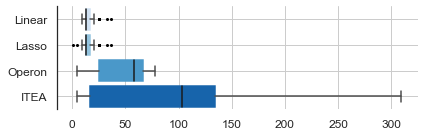

In [4]:
regression_analysis_results = results_regression_analysis_models('rmse_test', index=True)

fig, ax = plt.subplots(1, 1, figsize=(6, 2.0))

cols = [col_name for col_name in regression_analysis_results.columns if col_name.startswith('expr_size_')]

res_exprSize = regression_analysis_results.loc[:, cols]

meds = res_exprSize.median()
meds.sort_values(ascending=(True), inplace=True)
res_exprSize = res_exprSize[meds.index]

flierprops = dict(marker='o', markerfacecolor='black', markersize=2,  markeredgecolor='black')

sns.boxplot(data=res_exprSize, orient="h",medianprops={'color': 'k'},
    showfliers=True, ax=ax, flierprops=flierprops) #, x=x, y=y, order=order)

for box, color in zip(ax.artists, sns.color_palette("Blues", len(ax.artists))):
    box.set_color(color)

ax.set_yticklabels(
    [s.replace(f'expr_size_', '')
     for s in meds.index],
    rotation = 0, fontsize = 12, ha='right')

for spine in ['right', 'top', 'bottom']:
    ax.spines[spine].set_visible(False)

ax.grid()

plt.tight_layout()
plt.savefig(f'{analyzed_path}expression_sizes.pdf', bbox_inches='tight')
plt.show()

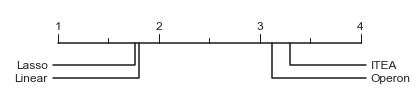

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(6, 1.5))
    
res_exprSize.columns = [col.replace('expr_size_', '') for col in res_exprSize.columns]

melted_res = pd.melt(res_exprSize.reset_index(), id_vars=['dataset'])
melted_res.columns = ['dataset_name', 'classifier_name', 'accuracy']


melted_res['accuracy'] = np.max(melted_res['accuracy']) - melted_res['accuracy']
    
draw_cd_diagram(
    df_perf=melted_res,
    labels=False, ax=axs, width=8, textspace=1.0, reverse=False)

plt.tight_layout()
plt.savefig(f'{analyzed_path}expression_sizes_criticaldiagram.pdf', bbox_inches='tight')
plt.show()